# Automatic Detection of Mosquito Breeding Grounds

### Divide MBG videos into frame by frame

In [1]:
# import cv2
# import os
# import xml.etree.ElementTree as ET

# def read_annotations(xml_file):
#     tree = ET.parse(xml_file)
#     root = tree.getroot()
#     annotations = {}

#     for track in root.findall(".//track"):
#         label = track.attrib["label"]

#         for box in track.findall(".//box"):
#             frame_number = int(box.attrib["frame"])
#             xmin = int(float(box.attrib["xtl"]))
#             ymin = int(float(box.attrib["ytl"]))
#             xmax = int(float(box.attrib["xbr"]))
#             ymax = int(float(box.attrib["ybr"]))

#             if frame_number not in annotations:
#                 annotations[frame_number] = []

#             annotations[frame_number].append({
#                 'label': label,
#                 'bbox': (xmin, ymin, xmax, ymax)
#             })

#     return annotations

# def convert_to_yolo_format(class_id, image_width, image_height, bbox):
#     x_center = (bbox[0] + bbox[2]) / 2 / image_width
#     y_center = (bbox[1] + bbox[3]) / 2 / image_height
#     width = (bbox[2] - bbox[0]) / image_width
#     height = (bbox[3] - bbox[1]) / image_height

#     return f"{class_id} {x_center} {y_center} {width} {height}"

# def split_video(video_path, xml_file, output_image_directory, output_annotation_directory, frame_rate=1):
#     cap = cv2.VideoCapture(video_path)
#     annotations = read_annotations(xml_file)

#     frame_number = 0
#     while True:
#         ret, frame = cap.read()
#         if not ret:
#             break

#         if frame_number in annotations:
#             image_height, image_width, _ = frame.shape

#             # Save the frame as an image
#             output_image_file = os.path.join(output_image_directory, f"frame_{frame_number:04d}.jpg")
#             cv2.imwrite(output_image_file, frame)

#             # Save YOLO format annotation to file
#             annotation_file_path = os.path.join(output_annotation_directory, f"frame_{frame_number:04d}.txt")
#             with open(annotation_file_path, 'w') as yolo_file:
#                 for annotation in annotations[frame_number]:
#                     xmin, ymin, xmax, ymax = annotation['bbox']
#                     label = annotation['label']

#                     # Get class_id from the class_ids dictionary
#                     class_id = class_ids.get(label)
#                     if class_id is not None:
#                         yolo_format = convert_to_yolo_format(class_id, image_width, image_height, (xmin, ymin, xmax, ymax))
#                         yolo_file.write(f"{yolo_format}\n")

#         # Create the output directories if they don't exist
#         os.makedirs(output_image_directory, exist_ok=True)
#         os.makedirs(output_annotation_directory, exist_ok=True)

#         # Save the frame if it's within the desired frame rate
#         if frame_number % int(cap.get(cv2.CAP_PROP_FPS) / frame_rate) == 0:
#             frame_number += 1
#             continue

#         frame_number += 1

#     cap.release()

# if __name__ == "__main__":
#     video_directory = "C:/Users/user/Downloads/FYP/fypfiles/mbgdataset/flightavi"
#     annotation_directory = "C:/Users/user/Downloads/FYP/fypfiles/mbgdataset/flightann"
#     output_image_directory = "C:/Users/user/Downloads/projects/MBGprocess/imageframes"
#     output_annotation_directory = "C:/Users/user/Downloads/projects/MBGprocess/labelframes"
#     frame_rate = 1

#     class_ids = {"tire": 0, "bottle": 1, "bucket": 2, "watertank": 3, "pool": 4, "puddle": 5}

#     video_files = [f for f in os.listdir(video_directory) if f.endswith(".avi")]

#     for video_file in video_files:
#         video_path = os.path.join(video_directory, video_file)
#         xml_file = os.path.join(annotation_directory, f"{os.path.splitext(video_file)[0]}.xml")
#         split_video(video_path, xml_file, output_image_directory, output_annotation_directory, frame_rate)


# Data Preprocessing

### Data Augmentation

In [2]:
!pip install imgaug

Defaulting to user installation because normal site-packages is not writeable


### Split to train, test, val set

In [3]:
import os
from sklearn.model_selection import train_test_split

# Set the path to the dataset directory
dataset_directory = "C:/Users/user/Downloads/projects/MBGprocess/"

# Set the paths for image and label folders
image_folder = os.path.join(dataset_directory, "imageframes")
label_folder = os.path.join(dataset_directory, "labelframes")

# Get lists of image and label files
image_files = os.listdir(image_folder)
label_files = os.listdir(label_folder)

# Ensure the lists are sorted for consistency
image_files.sort()
label_files.sort()

# Split the data into training, validation, and test sets
image_train_val, image_test, label_train_val, label_test = train_test_split(
    image_files, label_files, test_size=0.2, random_state=1
)
image_train, image_val, label_train, label_val = train_test_split(
    image_train_val, label_train_val, test_size=0.25, random_state=1
)

# Display the lengths of the sets
print("Train set size:", len(image_train))
print("Validation set size:", len(image_val))
print("Test set size:", len(image_test))

Train set size: 4533
Validation set size: 1511
Test set size: 1511


In [4]:
import imgaug as ia
from imgaug import augmenters as iaa
import cv2
import numpy as np

# Define augmentation pipeline
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontal flips
    iaa.Flipud(0.5),  # vertical flips
    iaa.SomeOf((0, 7),
               [
                   iaa.Affine(rotate=(-45, 45)),
                   iaa.Multiply((0.5, 1.5)),  # Adjust brightness
                   iaa.GaussianBlur(sigma=(0.0, 2.0)),
                   iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),
                   iaa.Crop(percent=(0, 0.2)),  # Random crop
                   iaa.Affine(shear=(-16, 16)),  # Random shear
                   iaa.GammaContrast((0.5, 2.0)),  # Exposure adjustment
                   iaa.AdditiveLaplaceNoise(scale=(0, 0.05 * 255)),  # Random noise
               ],
               random_order=True
               ),
    # Adding cutout augmentation
    iaa.Cutout(nb_iterations=1, size=0.1, squared=False, cval=(0, 255))
])


# Function to apply augmentation to an image and its bounding boxes
def augment_data(image_path, label_path):
    image = cv2.imread(os.path.join(image_folder, image_path))
    bboxes = []
    
    with open(os.path.join(label_folder, label_path), 'r') as f:
        lines = f.readlines()
        for line in lines:
            # Assuming YOLO format: class x_center y_center width height
            class_id, x_center, y_center, width, height = map(float, line.split()[0:5])
            
            # Convert YOLO format to xmin, ymin, xmax, ymax
            xmin = int((x_center - width / 2) * image.shape[1])
            ymin = int((y_center - height / 2) * image.shape[0])
            xmax = int((x_center + width / 2) * image.shape[1])
            ymax = int((y_center + height / 2) * image.shape[0])
            
            bboxes.append(ia.BoundingBox(x1=xmin, y1=ymin, x2=xmax, y2=ymax, label=int(class_id)))
    
    bbs = ia.BoundingBoxesOnImage(bboxes, shape=image.shape)
    
    # Apply augmentation
    augmented_image, augmented_bbs = seq(image=image, bounding_boxes=bbs)
    
    # Convert augmented bounding boxes back to YOLO format
    augmented_labels = []
    for bb in augmented_bbs.bounding_boxes:
        class_id = bb.label
        x_center = (bb.x1 + bb.x2) / 2 / augmented_image.shape[1]
        y_center = (bb.y1 + bb.y2) / 2 / augmented_image.shape[0]
        width = (bb.x2 - bb.x1) / augmented_image.shape[1]
        height = (bb.y2 - bb.y1) / augmented_image.shape[0]
        augmented_labels.append(f"{int(class_id)} {x_center} {y_center} {width} {height}\n")
    
    return augmented_image, augmented_labels

# Example: Apply augmentation to the first image and its labels in the training set
image_path_train_1 = image_train[0]
label_path_train_1 = label_train[0]
augmented_image_train_1, _ = augment_data(image_path_train_1, label_path_train_1)

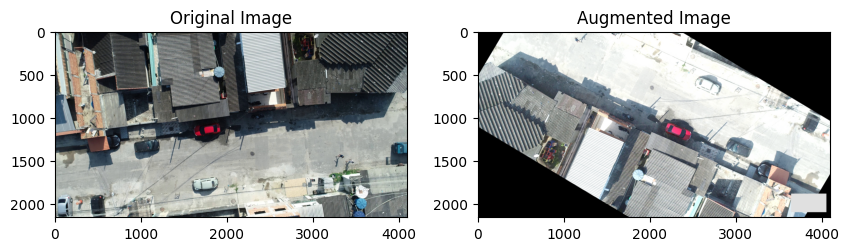

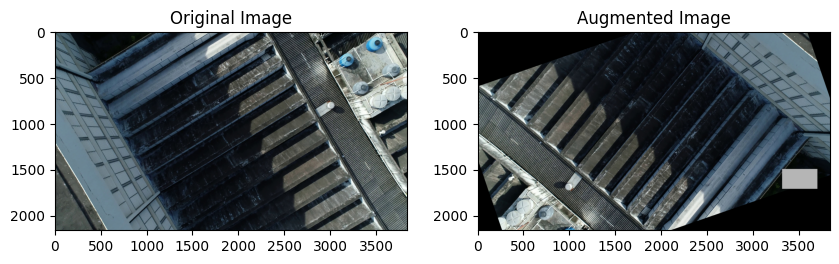


Number of images in the original train set: 4533
Number of images in the new train set (including augmented images): 13599


In [11]:
import matplotlib.pyplot as plt

# Visualization function
def visualize_images(original_image, augmented_image):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
    plt.title('Augmented Image')

    plt.show()

import random

# Display two random samples of original and augmented images
for _ in range(2):
    # Select a random image from the original train set
    random_index = random.randint(0, len(image_train) - 1)
    original_image_path = image_train[random_index]
    original_label_path = label_train[random_index]

    # Apply augmentation to the selected image
    augmented_image, _ = augment_data(original_image_path, original_label_path)

    # Load original and augmented images for visualization
    original_image = cv2.imread(os.path.join(image_folder, original_image_path))
    
    # Display the images
    visualize_images(original_image, augmented_image)

# Print the number of images in the original train set and the new train set
num_images_original_train = len(image_train)
num_augmentations = 2  # Assuming two augmentations for each original image
num_images_new_train_set = num_images_original_train * (1 + num_augmentations)
print("\nNumber of images in the original train set:", num_images_original_train)
print("Number of images in the new train set (including augmented images):", num_images_new_train_set)


## YOLOv7

In [6]:
#!git clone https://github.com/WongKinYiu/yolov7.git

### Train

In [7]:
%cd yolov7
!pip install -r requirements.txt

c:\Users\user\Downloads\projects\MBG-YOLOv7\yolov7
Defaulting to user installation because normal site-packages is not writeable


In [8]:
# Train YOLOv5s on MBG dataset
# !python train.py --img 512 --batch 32 --epochs 30 --data mbg_test.yaml --weights yolov5s.pt --cache

### Detect Images

In [9]:
# !python detect.py --source runs/train/exp/test1.jpg --weights best.pt